 ## カウントベースの手法
 ### Pythonによる下準備

In [5]:
text = 'You say goodbye and I say hello.'

text = text.lower()

text

'you say goodbye and i say hello.'

In [6]:
words = text.split(' ')

words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello.']

In [7]:
import re

re.split('(\W+)?', text)

/Users/saito/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


['you',
 ' ',
 'say',
 ' ',
 'goodbye',
 ' ',
 'and',
 ' ',
 'i',
 ' ',
 'say',
 ' ',
 'hello',
 '.',
 '']

In [9]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word


In [10]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello.'}

In [11]:
word_to_id

{'and': 3, 'goodbye': 2, 'hello.': 5, 'i': 4, 'say': 1, 'you': 0}

In [12]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)

corpus

array([0, 1, 2, 3, 4, 1, 5])

In [14]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### 単語の分散表現

### 単語の分散仮説

### 共起行列(co-occurence matrix)

In [15]:
import sys
sys.path.append('..')
import numpy as np

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)

[0 1 2 3 4 1 5 6]


In [16]:
# 語彙数が全部で7個であることがわかる
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [19]:
# 単語の頻度を数える
# コンテキストに含まれる単語の数を数え，表の形式にまとめる．これが共起行列
C = np.array([
    [0,1,0,0,0,0,0],
    [1,0,1,0,1,1,0],
    [0,1,0,1,0,0,0],
    [0,0,1,0,1,0,0],
    [0,1,0,1,0,0,0],
    [0,1,0,0,0,0,1],
    [0,0,0,0,0,1,0],
], dtype=np.int32)

# 単語1のベクトル
print("C[0] = {c0}".format(c0=C[0]))

# 'goodbye' のベクトル
print("C[word_to_id['goodbye']] = {c}".format(c=C[word_to_id['goodbye']]))

C[0] = [0 1 0 0 0 0 0]
C[word_to_id['goodbye']] = [0 1 0 1 0 0 0]


In [20]:
# 共起行列の生成を自動化したい
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''共起行列の作成

    :param corpus: コーパス（単語IDのリスト）
    :param vocab_size:語彙数
    :param window_size:ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return: 共起行列
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

### ベクトル間の類似度
いくつかの方法
* ベクトルの内積
* ユークリッド距離
* コサイン類似度(cosine similarity)
    * 同じ向きならば1，反対ならば-1となる

$$
similarity(x,y) = \frac{x \cdot y}{||x|| ||y||}
= \frac{x_1y_1+...+x_ny_n}{\sqrt{x^2_1+...+x^2_n}\sqrt{y^2_1+...+y^2_n}}
$$

In [21]:
def cos_similarity(x, y, eps=1e-8):
    '''コサイン類似度の算出

    :param x: ベクトル
    :param y: ベクトル
    :param eps: ”0割り”防止のための微小値
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

0.7071067691154799


### 類似単語のランキング表示

In [22]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''類似単語の検索

    :param query: クエリ（テキスト）
    :param word_to_id: 単語から単語IDへのディクショナリ
    :param id_to_word: 単語IDから単語へのディクショナリ
    :param word_matrix: 単語ベクトルをまとめた行列。各行に対応する単語のベクトルが格納されていることを想定する
    :param top: 上位何位まで表示するか
    '''
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


## カウントベース手法の改善
### 相互情報量
* 共起行列の要素の値（カウント数）はあまり良い性質を持たない
    * 高頻度単語が常に関連性の高いワードとして挙げられてしまう

相互情報量の定義

$$
PMI(x,y) = \log_2{\frac{P(x,y)}{P(x)P(y)}}
= \log_2{\frac{\frac{C(x,y)}{N}}{\frac{C(x)}{N}\frac{C(y)}{N}}}
= \log_2{\frac{C(x,y)\cdot N}{C(x)C(y)}}
$$
ここで
* N: ワード数
* C(x) : xの出現回数
* C(x,y): xとyの共起回数

In [23]:
def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI（正の相互情報量）の作成

    :param C: 共起行列
    :param verbose: 進行状況を出力するかどうか    
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [27]:
W = ppmi(C)

# 共起行列をPPMI行列に変換する
np.set_printoptions(precision=3)
print('covariance matrix = \n{c}'.format(c=C))
print('-'*50)
print('PPMI = \n{w}'.format(w=W))


covariance matrix = 
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI = 
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 次元削減
* PPMI 行列の問題点
    * ほとんどの要素が0である．これは各要素の重要度が低いことを意味する
    * そのようなベクトルはノイズに弱く，頑健性に乏しい
* 次元削減とは
    * ベクトルを，重要な情報を残しつつ，次元を削減すること
    * データの分布をみて重要な軸を見つけることを行い，次元を削減する
    * 次元削減したベクトルは0の要素が少ない，密な行列となる．これが望ましい分散表現である
* 次元削減の方法：特異値分解(Singular Value Decomposition: SVD)
$$
X = USV^T
$$
ここで
* U,V : 直交行列．列ベクトルは互いに直交
* S : 対角行列．対角成分以外はすべて0

それぞれの行列の特徴
* U はなんらかの空間の軸（基底）を形成する．この行列を単語空間として扱うことができる
* S の対角成分には「特異値」，つまり対応する軸の重要度が大きい順に並んでいる
    * そこで，重要でない軸を削除することで次元を削減することができる

In [28]:
# 特異値分解を行う
U, S, V = np.linalg.svd(W)

print(U)
print(S)
print(V)

[[ 3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01 -9.323e-01  0.000e+00
   1.958e-17]
 [ 0.000e+00 -5.976e-01  1.802e-01  0.000e+00  0.000e+00 -7.812e-01
   0.000e+00]
 [ 4.363e-01 -5.551e-17 -2.220e-16 -5.088e-01  2.253e-01 -1.388e-17
  -7.071e-01]
 [ 1.110e-16 -4.978e-01  6.804e-01  2.776e-17 -1.110e-16  5.378e-01
   9.555e-17]
 [ 4.363e-01 -3.124e-17 -1.600e-16 -5.088e-01  2.253e-01 -1.302e-17
   7.071e-01]
 [ 7.092e-01 -3.124e-17 -1.600e-16  6.839e-01  1.710e-01 -1.302e-17
   1.342e-16]
 [-1.943e-16 -6.285e-01 -7.103e-01 -2.776e-17  3.331e-16  3.169e-01
  -1.230e-16]]
[ 3.168  3.168  2.703  2.703  1.514  1.514 -0.   ]
[[-0.000e+00  5.976e-01  1.110e-16  4.978e-01  2.776e-16 -2.776e-16
   6.285e-01]
 [-3.409e-01 -2.220e-16 -4.363e-01  0.000e+00 -4.363e-01 -7.092e-01
   0.000e+00]
 [ 1.205e-01 -5.551e-16  5.088e-01  0.000e+00  5.088e-01 -6.839e-01
   0.000e+00]
 [ 0.000e+00 -1.802e-01 -1.527e-16 -6.804e-01  1.388e-17  8.327e-17
   7.103e-01]
 [ 0.000e+00 -7.812e-01 -1.665e-16  5.378e-01 

In [29]:
# U を次元削減するとしたら，先頭の2列を取り出すようなスライスによって表現する
print(U[:, :2])

[[ 3.409e-01 -1.110e-16]
 [ 0.000e+00 -5.976e-01]
 [ 4.363e-01 -5.551e-17]
 [ 1.110e-16 -4.978e-01]
 [ 4.363e-01 -3.124e-17]
 [ 7.092e-01 -3.124e-17]
 [-1.943e-16 -6.285e-01]]


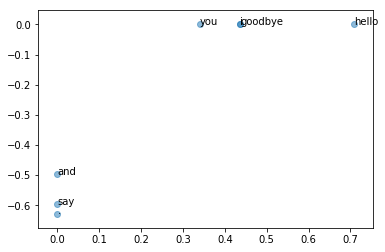

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

### PTBデータセット
もう少し規模の大きいコーパスとしてPenn Treebank と呼ばれるコーパスを使ってみる

In [31]:
import sys
sys.path.append('book_sample')
from dataset import ptb

corpus_ptb, word_to_id_ptb, id_to_word_ptb = ptb.load_data('train')

print('corpus_size', len(corpus_ptb))
print('corpus[:30]:',corpus_ptb[:30])
print()
print('id_to_word[0]:', id_to_word_ptb[0])
print('id_to_word[1]:', id_to_word_ptb[1])
print('id_to_word[2]:', id_to_word_ptb[2])
print()
print('word_to_id["car"]:', word_to_id_ptb['car'])
print('word_to_id["happy"]:', word_to_id_ptb['happy'])
print('word_to_id["lexus"]:', word_to_id_ptb['lexus'])

corpus_size 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id["car"]: 3856
word_to_id["happy"]: 4428
word_to_id["lexus"]: 7426


In [32]:
# PTBデータセットでの評価
# ある単語を入力して，それに類似した単語の上位いくつかをPTBコーパスから取ってくる

# このセルの実行の前提
#     most_similar, create_to_matrix, ppmi が定義済みである
#     PTB の load_data は実行済みである

window_size_ptb = 2
wordvec_size_ptb = 100

vocab_size_ptb = len(word_to_id_ptb)

print('counting co-occurrence ...')
C = create_co_matrix(corpus_ptb, vocab_size_ptb, window_size_ptb)

print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')

try:
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size_ptb, n_iter=5, random_state=None)
except ImportError:
    U, S, V = np.linglg.svd(W)

word_vecs_ptb = U[:, :wordvec_size_ptb]

queries = ['you','year','car','toyota']

for query in queries:
    most_similar(query, word_to_id_ptb, id_to_word_ptb, word_vecs_ptb, top=5)


counting co-occurrence ...
calculating PPMI ...
1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0